In [ ]:
%reset -f 
from helpers import multiply_with_overflow, normalize, random_chunk2, Assay, AutoEncoder, IDs0, IDs1, labels, train
from helpers import create_assay, generate_assays, extract_data, generate_data
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
from multiprocessing import Pool
import matplotlib.pyplot as plt
import math, pickle, sys, cv2, os, subprocess
%matplotlib inline
[train_chunk_data, test_chunk_data, train_chunk_labels, test_chunk_labels] = pickle.load(open('data/data.py','rb'))

# t-SNE clustering does not differentiate classes

### Data

Currently for a single run, I am generating data where I sample 10 chunks per image, for each of the 4 repititions of the IDs rescaling from 200 pixels to 64 pixels. I have 5480 training chunks and 1400 test chunks along with the corresponding labels.

In [38]:
[x.shape for x in [np.array(train_chunk_data), np.array(test_chunk_data), np.array(train_chunk_labels), np.array(test_chunk_labels)]]

[(5480, 64, 64, 3), (1400, 64, 64, 3), (5480,), (1400,)]

### Training

I train an autoencoder on the training data for 200 epochs and observe to test cost during training. This seems to be decreasing nicely.

In [3]:
params = {'learning_rate': 0.002,
            'training_epochs': 500,
            'batch_size': 100,
            'display_step': 50,
            'keep_prob': 0.7,
            'final_layer': 1000}

A = AutoEncoder(params)

A.fit(train_chunk_data, test_chunk_data, train_chunk_labels, test_chunk_labels)

Epoch: 1, train cost= 0.022484068, test cost= 0.026565796, speed: 71347.5324 chunks p/s
Epoch: 51, train cost= 0.010205053, test cost= 0.010163446, speed: 3856.6256 chunks p/s
Epoch: 101, train cost= 0.006000442, test cost= 0.006339225, speed: 3851.5576 chunks p/s
Epoch: 151, train cost= 0.005002823, test cost= 0.005490075, speed: 3845.9778 chunks p/s
Saving model 200-1000-0.7
Training time: 291.788934946


### Displaying

Displaying the encoded and decoded images suggests that the encodings are lossy, but retain a reasonable proportion of the chunks of data.

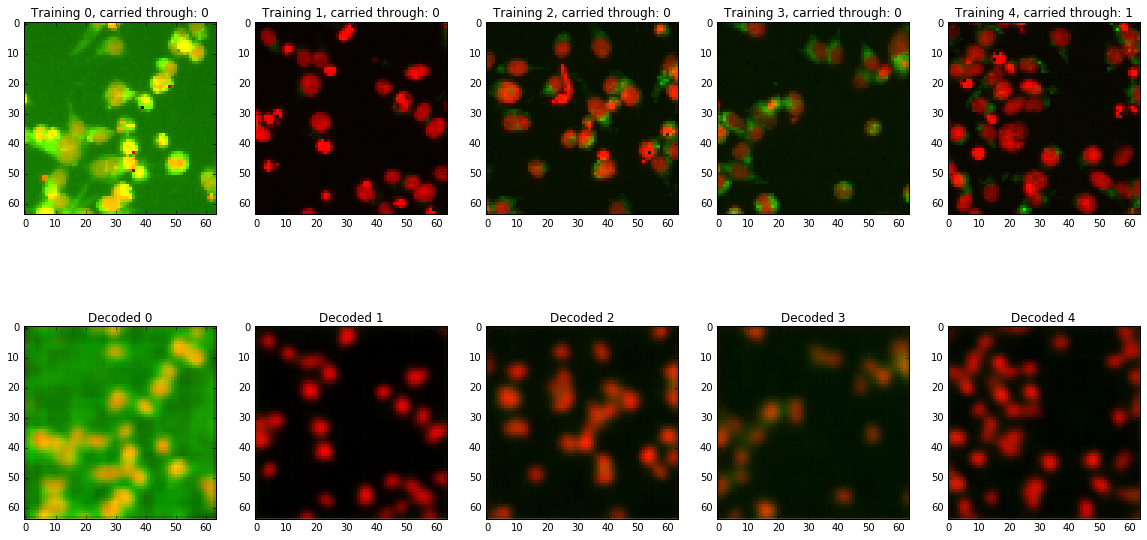

In [42]:
A.display_train()

Even the test images that were not fed into the network at all, seem to encode reasonably well. Remember these images have never been seen by the network.

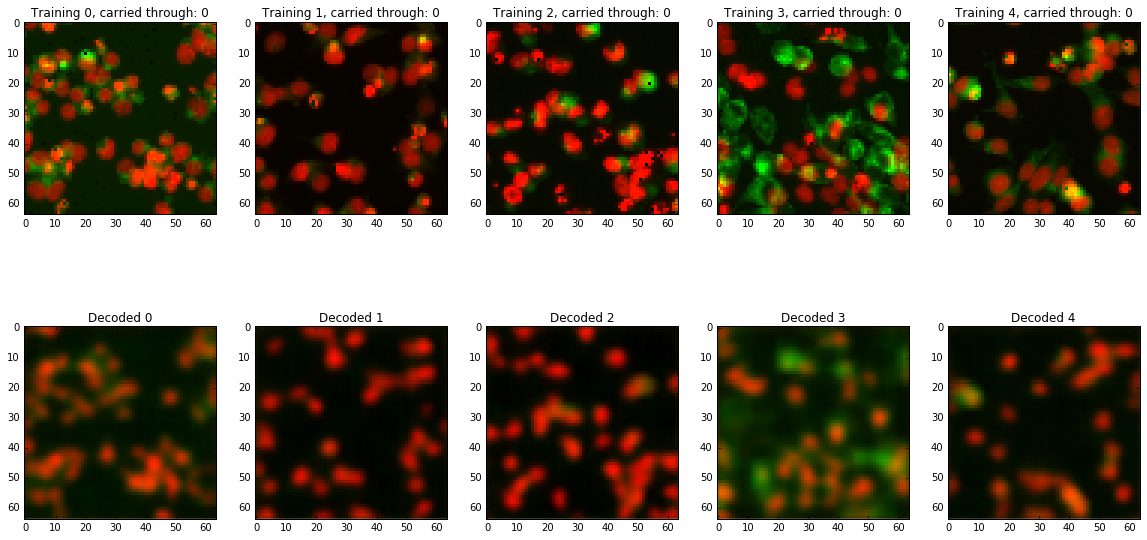

In [40]:
A.display_test()

However, when I plot a TSNE of the encodings, no latent structure seems to emerge

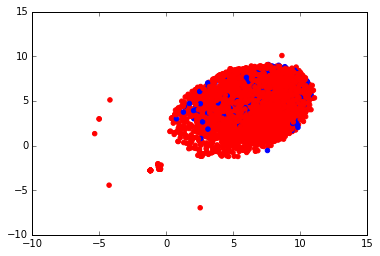

In [23]:
model = TSNE(n_components=2, random_state=0, perplexity=100)
points = model.fit_transform(A.encoded_train) 
painter = ['red','blue']
plt.scatter([x[0] for x in points],[x[1] for x in points], color=[painter[train_chunk_labels[i]] for i in range(len(points))])

By contrast, the same process on the MNIST dataset reveals some latent structure

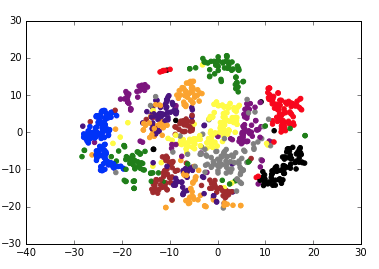

In [49]:
Image('MNISTstructure.png')

Here is a PCA of the encodings. There seems to be more structure but nothing that differentiates the blues or the reds

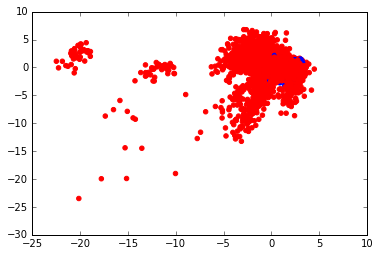

In [51]:
pca = PCA(n_components=2)
pca_points = pca.fit_transform(A.encoded_train)

painter = ['red','blue']
plt.scatter([x[0] for x in pca_points],[x[1] for x in pca_points], color=[painter[train_chunk_labels[i]] for i in range(len(pca_points))])